# Código para cuando es por año

##ParaguayFeatureBased_Incidencia.ipynb

In [1]:
%%capture
!pip install kats

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tsfeature as tsf
import sys
sys.path.append("../")

import pprint
from sklearn.decomposition import PCA
from kats.consts import TimeSeriesData
from statsmodels.tsa.seasonal import STL
from kats.utils.simulator import Simulator
from sklearn.preprocessing import StandardScaler
from kats.tsfeatures.tsfeatures import TsFeatures
from scipy.stats import entropy
from math import log, e

import warnings
warnings.simplefilter(action='ignore')

C:\ProgramData\Anaconda3\envs\kats\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Ver con glob para carpeta local
df= pd.read_csv('notificaciones_clima_7_dias_COMBINADO_SEMANAL.csv', sep=';')
poblacion= pd.read_csv('Poblacion_Paraguay.csv', sep=',')

In [4]:
poblacion['#'] = poblacion['#'].str.upper()
poblacion = poblacion.head(268)
poblacion.rename(columns = {'#':'Ciudad'}, inplace = True)

In [5]:
poblacion['Ciudad'].iloc[1] == df['distrito_notif'].iloc[0]

True

In [6]:
print("La cantidad de ciudades con casos es:", df['distrito_notif'].nunique())
print("La cantidad de ciudades con datos de población:", poblacion['Ciudad'].nunique())

La cantidad de ciudades con casos es: 238
La cantidad de ciudades con datos de población: 266


In [7]:
S1 = set(list(dict.fromkeys(df['distrito_notif'].tolist())))
S2 = set(list(dict.fromkeys(poblacion['Ciudad'].tolist())))
ciudades = S1.intersection(S2)
ciudades = list(ciudades)
ciudades

['COLONIA INDEPENDENCIA',
 'ITACURUBI DEL ROSARIO',
 'CAPITAN MEZA',
 'AYOLAS',
 'HORQUETA',
 'SAN RAFAEL DEL PARANA',
 'MBOCAYATY',
 'JOSE DOMINGO OCAMPOS',
 'SAN PEDRO',
 'TRINIDAD',
 'VILLA OLIVA',
 'JUAN EULOGIO ESTIGARRIBIA',
 'BORJA',
 'CARLOS ANTONIO LOPEZ',
 'NUEVA ESPERANZA',
 'SAN COSME Y DAMIAN',
 'AZOTEY',
 'TOMAS ROMERO PEREIRA',
 'YATAITY',
 'GENERAL BRUGUEZ',
 'DESMOCHADOS',
 'SAN LAZARO',
 'PUERTO PINASCO',
 'CORONEL BOGADO',
 'SAN BERNARDINO',
 'HERNANDARIAS',
 'SAN LORENZO',
 'EUSEBIO AYALA',
 'CAPIATA',
 'QUIINDY',
 'MBARACAYU',
 'HOHENAU',
 'MINGA PORA',
 'PARAGUARI',
 'ITAKYRY',
 'EMBOSCADA',
 'ESCOBAR',
 'YPANE',
 'JOSE FALCON',
 'CAAZAPA',
 'JUAN DE MENA',
 'NUEVA ITALIA',
 'NUEVA ALBORADA',
 'ISLA PUCU',
 'PIRAYU',
 'CAPITAN MIRANDA',
 '3 DE FEBRERO',
 'TAVAPY',
 'FRAM',
 'MACIEL',
 'JUAN E. OLEARY',
 'VAQUERIA',
 'SAPUCAI',
 'BELLA VISTA',
 'CAACUPE',
 'ITACURUBI DE LA CORDILLERA',
 'FELIX PEREZ CARDOZO',
 'SAN ALBERTO',
 'YABEBYRY',
 'LAURELES',
 'VALENZUELA',

In [8]:
df = df[['anio','distrito_notif', 'semana', 'casos']]

In [9]:
df.rename(columns = {'anio':'Año', 'distrito_notif':'Distrito'}, inplace = True)
#print(df)
df = df[df['Distrito'].isin(ciudades)]
#print(df)
listaDistrito = df['Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
print(listaDistrito)

['ASUNCION', 'FERNANDO DE LA MORA', 'PEDRO JUAN CABALLERO', 'YBY YAU', 'YPANE', 'CAPIATA', 'CAPITAN BADO', 'HORQUETA', 'BELEN', 'CECILIO BAEZ', 'CONCEPCION', 'LAMBARE', 'BELLA VISTA', 'HERNANDARIAS', 'ITAKYRY', 'ITAUGUA', 'CORONEL OVIEDO', 'LOMA PLATA', 'LUQUE', 'MCAL. ESTIGARRIBIA', 'MINGA GUAZU', 'PIRAYU', 'SAN ALBERTO', 'VILLA ELISA', 'YAGUARON', 'YPACARAI', 'CAACUPE', 'EMBOSCADA', 'ITA', 'LIMPIO', 'MARIANO ROQUE ALONSO', 'SAN LORENZO', 'VILLETA', 'GUARAMBARE', 'J A SALDIVAR', 'SAN JOSE DE LOS ARROYOS', 'CAAGUAZU', 'JUAN LEON MALLORQUIN', 'LORETO', 'NUEVA ITALIA', 'VILLA HAYES', 'ACAHAY', 'CARAPEGUA', 'CHORE', 'ENCARNACION', 'FRAM', 'JOSE DOMINGO OCAMPOS', 'JUAN E. OLEARY', 'PARAGUARI', 'REPATRIACION', 'SAN ANTONIO', 'SAN JUAN NEPOMUCENO', 'SANTA ROSA', 'LOMA GRANDE', 'SAN BERNARDINO', 'SAN ESTANISLAO', 'AREGUA', 'ARROYOS Y ESTEROS', 'EUSEBIO AYALA', 'ITACURUBI DE LA CORDILLERA', 'LA PALOMA', 'MINGA PORA', 'PILAR', 'SALTO DEL GUAIRA', 'SAN PEDRO', 'VILLARRICA', 'ALBERDI', 'CAMBYRETA

In [10]:
pob = []
for year in list(range(2009,2014)):
    aux = df[df['Año'] == year]
    for dis in aux.Distrito.values:
        pob.append(int(poblacion[poblacion.Ciudad == dis][str(year)].values[0]))   
print(len(pob))

7276


In [11]:
df['Poblacion'] = pob

In [12]:
df['incidencia'] = (df.casos/df.Poblacion)*100000
df

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2009,ASUNCION,2,2,531388,0.376373
1,2009,FERNANDO DE LA MORA,2,1,143116,0.698734
2,2009,PEDRO JUAN CABALLERO,2,2,103243,1.937177
3,2009,YBY YAU,2,4,25630,15.606711
4,2009,YPANE,2,1,36547,2.736203
...,...,...,...,...,...,...
8482,2013,VILLA HAYES,52,6,46033,13.034128
8483,2013,VILLETA,52,3,33890,8.852169
8484,2013,YAGUARON,52,1,30369,3.292832
8485,2013,YPACARAI,52,2,25002,7.999360


In [13]:
df['semana'] = df['semana'] + df['Año'].apply(lambda x: (x-2009)*53 if x>2009 else 0)
df.reset_index(drop=True)

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2009,ASUNCION,2,2,531388,0.376373
1,2009,FERNANDO DE LA MORA,2,1,143116,0.698734
2,2009,PEDRO JUAN CABALLERO,2,2,103243,1.937177
3,2009,YBY YAU,2,4,25630,15.606711
4,2009,YPANE,2,1,36547,2.736203
...,...,...,...,...,...,...
7271,2013,VILLA HAYES,264,6,46033,13.034128
7272,2013,VILLETA,264,3,33890,8.852169
7273,2013,YAGUARON,264,1,30369,3.292832
7274,2013,YPACARAI,264,2,25002,7.999360


In [14]:
def run_length_encoding(x):
    """
    :param x: np.array
    :return: np.array
    """
    pos, = np.where(np.diff(x) != 0)
    pos = np.concatenate(([0], pos+1, [len(x)]))
    # rle = [(a,b,x[a]) for (a,b) in zip(pos[:-1],pos[1:])]
    rle = [b - a for (a, b) in zip(pos[:-1], pos[1:])]
    return rle


def hysteresis(x, th_lo, th_hi, initial=False):
    """
    :param x: np.array
    :param th_lo: float
    :param th_hi: float
    :param initial: ???
    :return:
    """
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    # prevent index error if ind is empty
    if not ind.size:
        return np.zeros_like(x, dtype=bool) | initial
    # from 0 to len(x)
    cnt = np.cumsum(lo_or_hi)
    return np.where(cnt, hi[ind[cnt-1]], initial)


def arg_longest_not_null(x):
    # pad with np.nan while finding where null
    m = np.concatenate(( [True], np.isnan(x), [True] ))
    # Start-stop limits
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
    # Get max interval, interval limits
    start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]
    return start, stop

In [15]:
class poly(object):
    """ Orthogonal polynomials

    Source:
        http://davmre.github.io/python/2013/12/15/orthogonal_poly
    """

    def __init__(self):
        self.degree = None
        self.z = None
        self.norm2 = None
        self.alpha = None

    def fit(self, x, degree=1):

        self.degree = degree

        n = degree + 1
        x = np.asarray(x).flatten()
        if degree >= len(np.unique(x)):
            raise ValueError("'degree' must be less than number of unique points")

        xbar = np.mean(x)
        x = x - xbar
        q, r = np.linalg.qr(np.fliplr(np.vander(x, n)))

        z = np.diag(np.diag(r))
        raw = np.dot(q, z)

        norm2 = np.sum(raw**2, axis=0)
        alpha = (np.sum((raw**2)*np.reshape(x, (-1, 1)), axis=0)/norm2 + xbar)[:degree]
        z = raw / np.sqrt(norm2)

        self.z = z
        self.norm2 = norm2
        self.alpha = alpha

    def predict(self, x):
        x = np.asarray(x).flatten()
        n = self.degree + 1
        z = np.empty((len(x), n))
        z[:, 0] = 1

        if self.degree > 0:
            z[:, 1] = x - self.alpha[0]

        if self.degree > 1:
            for i in np.arange(1, self.degree):
                z[:, i+1] = (x - self.alpha[i]) * z[:, i] - (self.norm2[i] / self.norm2[i-1]) * z[:, i-1]

        z /= np.sqrt(self.norm2)

        return z

# Fig Func

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as scale_data


def biplot_features(x, robust=False, scale=True,  col=None, **kwargs):
    X = x.dropna(axis=1, how='all').dropna(axis=0, how='any')

    if col is None:
        col = ("#000000", "darkred")
    else:
        col = [col] if not isinstance(col, (list, tuple)) else col
        col = np.unique(col)

        if len(col) == 1:
            col = np.repeat(col, 2)
        else:
            col = np.unique(col)[0:2]

    if scale:
        X = scale_data(X, with_mean=True, with_std=True)

    if robust:
        raise NotImplemented('Robust PCA has not been implemented yet')
    else:
        pca = PCA(n_components=2)
        pca.fit(X)
        proj_pca = pca.transform(X)

    plt.figure()
    plt.scatter(x=proj_pca[:, 0], y=proj_pca[:, 1], c=col)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [17]:
from numpy.lib.stride_tricks import sliding_window_view

In [18]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import boxcox_normmax
from statsmodels.sandbox.gam import AdditiveModel

try:
    from entropy import spectral_entropy
except ImportError:
    ENTROPY_PACKAGE_AVAILABLE = False
else:
    ENTROPY_PACKAGE_AVAILABLE = True

# features_hyndman
# https://github.com/robjhyndman/anomalous/blob/master/R/tsmeasures.R

_VARIABLE_COUNT = 0


def trim(x, trim=0.1):
    """Trimmed time series eliminating outliers's influence"""
    qtl = x.quantile([trim, 1 - trim])
    lo = qtl.iloc[0]
    hi = qtl.iloc[1]

    trim_x = x.copy()
    trim_x[(trim_x < lo) | (trim_x > hi)] = np.nan
    return trim_x


def first_order_autocorrelation(x):
    """First order of autocorrelation"""
    return x.autocorr(1)


def lumpiness(x, width):
    """Lumpiness

    Note:
        Cannot be used for yearly data
    """
    nr = len(x)
    start = np.arange(1, nr, step=width, dtype=int)
    end = np.arange(width, nr + width, step=width, dtype=int)

    nsegs = int(nr / width)

    varx = np.zeros(nsegs)

    for idx in range(nsegs):
        tmp = x[start[idx]:end[idx]]
        varx[idx] = tmp[~np.isnan(tmp)].var()

    lump = varx[~np.isnan(varx)].var()
    return lump


def rolling_level_shift(x, width):
    """Level shift

    Using rolling window
    """

    tmp = x.dropna()
    roll_mean = tmp.rolling(width).mean()

    try:
        level_shifts = roll_mean.diff(width).abs().max()
    except Exception:
        level_shifts = np.nan

    return level_shifts


def rolling_variance_change(x, width):
    """Variance change

    Using rolling window

    """
    tmp = x.dropna()

    roll_var = tmp.rolling(width).var()

    try:
        variance_change = roll_var.diff(width).abs().max()
    except Exception:
        variance_change = np.nan

    return variance_change


def n_crossing_points(x):
    """Number of crossing points"""
    mid_line = ((x.max() - x.min()) / 2.0)
    ab = (x <= mid_line).values
    len_x = len(x)
    p1 = ab[1:(len_x - 1)]
    p2 = ab[2:len_x]
    cross = (p1 & ~p2) | (p2 & ~p1)
    return cross.sum()


def flat_spots(x):
    """Flat spots using discretization"""

    try:
        cut_x = pd.cut(x, bins=10, include_lowest=True, labels=False)
        rle_x = run_length_encoding(cut_x)
        spots = max(rle_x)
    except Exception:
        spots = np.nan

    #  Any flat spot
    return spots


def trend_seasonality_spike_strength(x, freq):
    """Strength of trend and seasonality and spike"""
    cont_x = x.dropna()
    length_cont_x = len(cont_x)
    season = peak = trough = np.nan

    if length_cont_x < (2 * freq):
        trend = linearity = curvature = season = spike = peak = trough = np.nan
    else:

        if freq > 1:
            all_stl = sm.tsa.seasonal_decompose(cont_x, freq=freq)
            trend0 = all_stl.trend
            fits = trend0 + all_stl.seasonal
            adj_x = cont_x - fits
            v_adj = adj_x.var()
            detrend = cont_x - trend0
            deseason = cont_x - all_stl.seasonal
            peak = all_stl.seasonal.max()
            trough = all_stl.seasonal.min()
            remainder = all_stl.resid
            season = 0 if detrend.var() < 1e-10 else max(0, min(1, 1 - v_adj/detrend.var()))

        else:  # No seasonal component
            tt = np.array([range(length_cont_x)]).T

            _trend0_values = AdditiveModel(tt).fit(cont_x.values).mu
            trend0=pd.Series(_trend0_values, index=cont_x.index)
            remainder = cont_x - trend0
            deseason = cont_x - trend0
            v_adj = trend0.var()

        trend = 0 if deseason.var() < 1e-10 else max(0, min(1, 1 - v_adj/deseason.var()))

        n = len(remainder)
        v = remainder.var()
        d = (remainder - remainder.mean())**2
        varloo = (v * (n - 1) - d) / (n - 2)
        spike = varloo.var()
        pl = poly()
        pl.fit(range(length_cont_x), degree=2)
        result_pl = pl.predict(range(length_cont_x))  # [:, 2]

        X = sm.add_constant(result_pl, has_constant='add')
        ols_data = trend0.copy()
        ols_data = pd.concat([ols_data.reset_index(drop=True), pd.DataFrame(X)], axis=1, ignore_index=True)
        ols_data.columns = ['Y', 'Intercept', 'X1', 'X2', 'X3']
        result_ols = ols('Y ~ X1 + X2 + X3', data=ols_data.dropna())

        trend_coef = result_ols.fit().params
        linearity = trend_coef[1]
        curvature = trend_coef[2]

    result = dict(trend=trend, spike=spike, peak=peak, trough=trough, linearity=linearity, curvature=curvature)

    if freq > 1:
        result["season"] = season

    return result


def kullback_leibler_score(x, window, threshold=None):
    """Kullback-Leibler score"""

    if threshold is None:
        threshold = norm.pdf(38)

    gw = 100  # grid width
    xgrid = np.arange(x.min(), x.max(), step=(x.max() - x.min()) / gw, dtype=float)
    grid = xgrid[1] - xgrid[0]
    tmpx = x[~x.isnull()]  # Remove NA to calculate bw
    bw = gaussian_kde(tmpx).covariance_factor()
    len_x = len(x)

    if len_x <= (2 * window):
        raise ValueError("Cannot compute KLscore when the length is too small.")

    dens_mat = np.zeros((len_x, gw))

    for i in range(len_x):
        dens_mat[i, :] = norm.pdf(xgrid, x[i], bw)

    dens_mat = np.clip(dens_mat, threshold, None)
    #print(dens_mat.shape)
    #dens_mat = dens_mat.to_frame()
    rmean = sliding_window_view(dens_mat, window_shape = window, axis=1)#.mean()
    rmean = rmean.mean(axis=(2))
    #print(rmean.shape)
    lo = list(range(len_x - window + 1))
    hi = list(range(window + 1, len_x))
    seqidx = min(len(lo), len(hi))
    kl = np.zeros(seqidx)
    
    for i in range(seqidx):
        kl[i] = np.sum(rmean[lo[i], ] * (np.log(rmean[lo[i], ]) - np.log(rmean[hi[i], ])) * grid)
    diffkl = pd.Series(kl).dropna().diff()
    maxidx = np.argmax(diffkl)
    return dict(score=np.max(diffkl), change_idx=maxidx)


def boxcox_optimal_lambda(x):
    y = x + 0.0000001 if np.any(x == 0) else x
    return boxcox_normmax(y)


# TODO: implement Spectral Entropy
def entropy(x, freq=1, normalize=False):
    """
    Spectral Entropy
    """
    try:
        start, stop = arg_longest_not_null(x)
        result = spectral_entropy(x[start:stop], sf=freq, method='welch', normalize=normalize)
    except Exception:
        result = np.nan
    finally:
        return result


def ts_measures(x, freq=1, normalize=True, width=None, window=None):
    """
    See `ts_measures_series` doc
    """

    if isinstance(x, pd.Series):
        measures_df = ts_measures_series(x, freq=freq, normalize=normalize, width=width, window=window)
    elif isinstance(x, pd.DataFrame):
        _buffer = []
        for c in x.columns:
            _buffer.append(ts_measures_series(x[c], freq=freq, normalize=normalize, width=width, window=window))
        measures_df = pd.concat(_buffer, axis=0)

    elif issubclass(x.__class__, pd.core.groupby._GroupBy):
        _buffer = []
        for i in x.groups:
            _buffer.append(ts_measures(x.get_group(i), freq=freq, normalize=normalize, width=width, window=window))

        measures_df = pd.concat(_buffer, axis=0)
    else:
        raise TypeError('Unhandled input type')

    return measures_df


def ts_measures_series(x, freq=1, normalize=True, width=None, window=None):
    """
    :param x: a uni-variate time series
    :param freq: number of points to be considered as part of a single period for trend_seasonality_spike_strength
    :param normalize: TRUE: scale data to be normally distributed
    :param width: a window size for variance change and level shift, lumpiness
    :param window: a window size for KLscore
    :return:
    """
    name = x.name

    if width is None:
        width = freq if freq > 1 else 10

    if window is None:
        window = width

    if (width <= 1) | (window <= 1):
        raise ValueError("Window widths should be greater than 1.")

    # Remove columns containing all NAs
    if x.isnull().all():
        raise ValueError("All values are null")

    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))

    trimx = trim(x)

    measures = dict()
    measures['lumpiness'] = lumpiness(x, width=width)
    if ENTROPY_PACKAGE_AVAILABLE:
        measures['entropy'] = entropy(x, freq=freq, normalize=False)
    measures['ACF1'] = first_order_autocorrelation(x)
    measures['lshift'] = rolling_level_shift(trimx, width=width)
    measures['vchange'] = rolling_variance_change(trimx, width=width)
    measures['cpoints'] = n_crossing_points(x)
    measures['fspots'] = flat_spots(x)
    #  measures['mean'] = np.mean(x)
    #  measures['var'] = np.var(x)

    varts = trend_seasonality_spike_strength(x, freq=freq)
    measures['trend'] = varts['trend']
    measures['linearity'] = varts['linearity']
    measures['curvature'] = varts['curvature']
    measures['spikiness'] = varts['spike']

    if freq > 1:
        measures['season'] = varts['season']
        measures['peak'] = varts['peak']
        measures['trough'] = varts['trough']

    threshold = norm.pdf(38)

    try:
        kl = kullback_leibler_score(x, window=window, threshold=threshold)
        measures['KLscore'] = kl['score']
        measures['change_idx'] = kl['change_idx']
    except Exception:
        measures['KLscore'] = np.nan
        measures['change_idx'] = np.nan

    measures['boxcox'] = boxcox_optimal_lambda(x)

    # Build output
    measures_df = pd.Series(measures).to_frame().transpose()
    measures_df.index = [x.index.min()] if isinstance(x, pd.Series) else [0]
    measures_df['variable'] = name if name is not None else generate_name()
    return measures_df

def generate_name(prefix='var_'):
    global _VARIABLE_COUNT
    output = "{}{}".format(prefix, _VARIABLE_COUNT)
    _VARIABLE_COUNT += 1
    return output

def entropy2(labels, base=None):
#""" Computes entropy of label distribution. """
    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

  # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)
    return ent

In [19]:
i=0
df1 = df[['Distrito','semana', 'incidencia']]
for dis in listaDistrito:
    df1.loc[df1['Distrito']==dis,'ID_distrito']=i
    i=i+1
df1

,Distrito,semana,incidencia,ID_distrito
0,ASUNCION,2,0.376373,0.0
1,FERNANDO DE LA MORA,2,0.698734,1.0
2,PEDRO JUAN CABALLERO,2,1.937177,2.0
3,YBY YAU,2,15.606711,3.0
4,YPANE,2,2.736203,4.0
...,...,...,...,...
8482,VILLA HAYES,264,13.034128,40.0
8483,VILLETA,264,8.852169,32.0
8484,YAGUARON,264,3.292832,24.0
8485,YPACARAI,264,7.999360,25.0


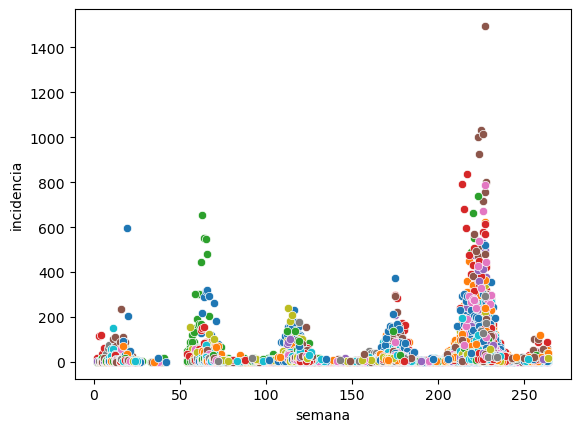

In [20]:
timeSeries = pd.DataFrame()
#listaDistrito = listaDistrito[0:15]
for dis in listaDistrito:
    distrito=df[df['Distrito']==dis]
    distrito.sort_values(['semana'], ascending = True)
    distrito = distrito.reset_index(drop=True)
    distrito = distrito.replace('nan', np.nan).fillna(0.00000000001)
    distrito = distrito.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    timeSeries = timeSeries.append(distrito['incidencia'], ignore_index=True)
    #print(dis)
    ax = sns.scatterplot(y=distrito['incidencia'], x= distrito['semana'])
plt.show()

In [21]:
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.00000000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)

In [22]:
df1

,Distrito,semana,incidencia,ID_distrito
0,ASUNCION,2,0.376373,0.0
1,FERNANDO DE LA MORA,2,0.698734,1.0
2,PEDRO JUAN CABALLERO,2,1.937177,2.0
3,YBY YAU,2,15.606711,3.0
4,YPANE,2,2.736203,4.0
...,...,...,...,...
8482,VILLA HAYES,264,13.034128,40.0
8483,VILLETA,264,8.852169,32.0
8484,YAGUARON,264,3.292832,24.0
8485,YPACARAI,264,7.999360,25.0


In [23]:
#from tsfeatures import tsfeatures
#df2 = df1[['ID_distrito', 'incidencia', 'semana']]
#df2 = df2.reset_index(drop=True)
#df2.rename(columns = {'ID_distrito':'unique_id', 'incidencia':'y', 'semana':'ds'}, inplace = True)

In [24]:
lista_aux = timeSeries.values.tolist()
#print(lista_aux)

In [25]:
model = TsFeatures()
aux = timeSeries.loc[[1]].T
aux['time'] = aux.index
aux = aux[['time', 1]]
aux = aux.rename(columns={1: "value"})
aux

,time,value
0,0,6.987339e-01
1,1,2.794936e+00
2,2,2.794936e+00
3,3,1.117974e+01
4,4,6.288605e+00
...,...,...
189,189,1.000000e-11
190,190,1.000000e-11
191,191,1.000000e-11
192,192,1.000000e-11


In [26]:
output_features = model.transform(aux)

In [27]:
output_features

{'length': 194,
 'mean': 39.93412065311504,
 'var': 4510.790865786297,
 'entropy': 0.5129020111655705,
 'lumpiness': 5728113.227297807,
 'stability': 2966.3589750793826,
 'flat_spots': 17,
 'hurst': 0.47378797859670185,
 'std1st_der': 17.050754483458896,
 'crossing_points': 22,
 'binarize_mean': 0.27835051546391754,
 'unitroot_kpss': 0.6152168210057821,
 'heterogeneity': 135.91189264113436,
 'histogram_mode': 1e-11,
 'linearity': 0.021828092169286332,
 'trend_strength': 0.932633826737105,
 'seasonality_strength': 0.18159476983994893,
 'spikiness': 31.73285488790231,
 'peak': 3,
 'trough': 0,
 'level_shift_idx': 135,
 'level_shift_size': 18.74199162347722,
 'y_acf1': 0.9345473763907283,
 'y_acf5': 3.3707321614270773,
 'diff1y_acf1': 0.012347681048984977,
 'diff1y_acf5': 0.10371833279651178,
 'diff2y_acf1': -0.43499392945513327,
 'diff2y_acf5': 0.35967531247687023,
 'y_pacf5': 1.0128994805225744,
 'diff1y_pacf5': 0.10670915103589242,
 'diff2y_pacf5': 0.5990356399988024,
 'seas_acf1': 0.5

In [28]:
aux2 = timeSeries.loc[[19]].squeeze()
aux2
#aux2.name='TS'
kullback_leibler_score(aux2, 4)
#print(aux2.min()) 

{'score': 722.3380775220892, 'change_idx': 11}

In [29]:
y = ts_measures(timeSeries.T, freq= 8)
y.insert(0, "Distrito", listaDistrito, allow_duplicates=False)

In [30]:
y

,Distrito,lumpiness,ACF1,lshift,vchange,cpoints,fspots,trend,linearity,curvature,spikiness,season,peak,trough,KLscore,change_idx,boxcox,variable
0,ASUNCION,0.000230,0.894815,0.012681,0.000045,6.0,172.0,0.909154,0.003348,-0.907775,3.304063e-09,0.045511,0.014146,-0.015670,0.685101,6.0,0.100133,0
0,FERNANDO DE LA MORA,0.000126,0.936223,0.193182,0.014790,10.0,49.0,0.920280,0.007435,0.422249,2.526608e-09,0.033541,0.014395,-0.016979,0.626130,125.0,0.232950,1
0,PEDRO JUAN CABALLERO,0.000578,0.926201,0.067278,0.002212,2.0,58.0,0.879797,0.004259,-0.379223,4.087299e-09,0.044103,0.012278,-0.021042,0.681406,33.0,0.189217,2
0,YBY YAU,0.001255,0.755724,0.053125,0.002098,3.0,120.0,0.794669,0.003233,-0.615163,1.574891e-08,0.074806,0.036476,-0.021495,0.950908,48.0,0.265723,3
0,YPANE,0.000095,0.913022,0.139316,0.004833,4.0,84.0,0.913257,0.005405,-0.156748,3.080060e-09,0.032673,0.020228,-0.011978,0.937047,93.0,0.224125,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ISLA UMBU,0.000000,NaN,0.000000,0.000000,0.0,193.0,0.996072,0.000029,-0.008410,1.876283e-12,0.036486,0.000326,-0.002279,0.000000,2.0,8.472136,195
0,VILLA OLIVA,0.000000,NaN,0.000000,0.000000,0.0,193.0,0.996072,0.000029,-0.008410,1.876283e-12,0.036486,0.000326,-0.002279,0.000000,2.0,8.472136,196
0,CARMELO PERALTA,0.002264,0.814356,0.000000,0.000000,1.0,191.0,0.953513,0.000262,-0.075233,1.320797e-09,0.029645,0.002944,-0.010077,0.000000,1.0,8.248979,197
0,DESMOCHADOS,0.000000,NaN,0.000000,0.000000,0.0,193.0,0.996072,0.000029,-0.008410,1.876283e-12,0.036486,0.000326,-0.002279,0.000000,2.0,8.472136,198


In [31]:
entropy2(df[df["Distrito"]== 'ASUNCION']['incidencia'])

2.880550479972176

In [44]:
features = pd.DataFrame()
Mean=[]
Var=[]
aCF1=[]
Trend=[]
Linearity=[]
Curvature=[]
Season=[]
Peak=[]
Trough=[]
Entropy=[]
Lumpiness=[]
Spikiness=[]
Lshift=[]
Vchange=[]
Fspots=[]
Cpoints_ts=[]
Klscore=[]
ChangeIdx=[]
num = 0

for dis in listaDistrito:
    print(num)
    aux2 = timeSeries.loc[[num]].squeeze()
    distrito_1 = df['Distrito']==dis
    print(dis)
    casos_distrito1 = df[distrito_1]
    casos_distrito1 = casos_distrito1.reset_index(drop=True)
    casos_distrito1 = casos_distrito1['incidencia']
    casos_distrito1 = casos_distrito1.replace('nan', np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace(0, np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    #if (len(casos_distrito1)>8) :  
    try:
        #Extracción
        model = TsFeatures()
        #aux = timeSeries.loc[[1]].T
        aux= casos_distrito1.to_frame()
        aux['time'] = aux.index
        aux = aux.rename(columns={"incidencia": "value"})
        aux = aux[['time', 'value']]
        try:
            output_features = model.transform(aux)
            mean = output_features['mean']
            var = output_features['var'] 
            ACF1 = output_features['y_acf1']
            trend = output_features['trend_strength'][0]
            linear = output_features['linearity']
            curv = trend_seasonality_spike_strength(casos_distrito1, 4)['curvature']
            season = output_features['seasonality_strength']
            peak = output_features['peak']
            trough = output_features['trough']
            entropy = output_features['entropy']
            lump = output_features['lumpiness']
            spik = output_features['spikiness'] 
            lshift = output_features['level_shift_size']
            vchange = rolling_variance_change(casos_distrito1, 4)
            fspots = output_features['flat_spots']
            cpoints_ts = output_features['crossing_points']
            try:
                klscore = kullback_leibler_score(aux2, 4)['score']
                changeidx = kullback_leibler_score(aux2, 4)['change_idx']
            except:
                klscore = np.nan
                changeidx = np.nan
        except:
            mean = casos_distrito1.mean()
            var = casos_distrito1.var()
            ACF1 = y[y["Distrito"] == dis].ACF1
            trend = y[y["Distrito"] == dis].trend[0]
            linear = y[y["Distrito"] == dis].linearity
            curv = y[y["Distrito"] == dis].curvature
            season = y[y["Distrito"] == dis].season
            peak = y[y["Distrito"] == dis].peak
            trough = y[y["Distrito"] == dis].trough
            entropy = entropy2(casos_distrito1)
            lump = y[y["Distrito"] == dis].lumpiness
            spik = y[y["Distrito"] == dis].spikiness
            lshift = y[y["Distrito"] == dis].lshift
            vchange = y[y["Distrito"] == dis].vchange
            fspots = y[y["Distrito"] == dis].fspots
            cpoints_ = y[y["Distrito"] == dis].cpoints
            klscore = y[y["Distrito"] == dis].KLscore
            changeidx = y[y["Distrito"] == dis].change_idx
        
    #else:
    except:
        mean = np.nan
        var = np.nan
        ACF1 = np.nan
        trend = np.nan
        linear = np.nan
        curv = np.nan
        season = np.nan
        peak = np.nan
        trough = np.nan
        entropy = np.nan
        lump = np.nan
        spik = np.nan
        lshift = np.nan
        vchange = np.nan
        fspots = np.nan
        cpoints_ts = np.nan
        klscore = np.nan
        changeidx = np.nan

    Mean.append(mean)
    Var.append(var)
    aCF1.append(ACF1)
    Trend.append(trend)
    Linearity.append(linear)
    Curvature.append(curv)
    Season.append(season)
    Peak.append(peak)
    Trough.append(trough)
    Entropy.append(entropy)
    Lumpiness.append(lump)
    Spikiness.append(spik)
    Lshift.append(lshift)
    Vchange.append(vchange)
    Fspots.append(fspots)
    Cpoints_ts.append(cpoints_ts)
    Klscore.append(klscore)
    ChangeIdx.append(changeidx)
    num = num + 1

0
ASUNCION
1
FERNANDO DE LA MORA
2
PEDRO JUAN CABALLERO
3
YBY YAU
4
YPANE
5
CAPIATA
6
CAPITAN BADO
7
HORQUETA
8
BELEN
9
CECILIO BAEZ
10
CONCEPCION
11
LAMBARE
12
BELLA VISTA
13
HERNANDARIAS
14
ITAKYRY
15
ITAUGUA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


16
CORONEL OVIEDO
17
LOMA PLATA
18
LUQUE
19
MCAL. ESTIGARRIBIA
20
MINGA GUAZU
21
PIRAYU


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


22
SAN ALBERTO
23
VILLA ELISA
24
YAGUARON
25
YPACARAI
26
CAACUPE
27
EMBOSCADA
28
ITA
29
LIMPIO
30
MARIANO ROQUE ALONSO
31
SAN LORENZO
32
VILLETA
33
GUARAMBARE
34
J A SALDIVAR
35
SAN JOSE DE LOS ARROYOS
36
CAAGUAZU
37
JUAN LEON MALLORQUIN
38
LORETO
39
NUEVA ITALIA
40
VILLA HAYES
41
ACAHAY
42
CARAPEGUA
43
CHORE
44
ENCARNACION


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


45
FRAM
46
JOSE DOMINGO OCAMPOS
47
JUAN E. OLEARY
48
PARAGUARI
49
REPATRIACION
50
SAN ANTONIO


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


51
SAN JUAN NEPOMUCENO
52
SANTA ROSA
53
LOMA GRANDE
54
SAN BERNARDINO
55
SAN ESTANISLAO
56
AREGUA
57
ARROYOS Y ESTEROS
58
EUSEBIO AYALA
59
ITACURUBI DE LA CORDILLERA
60
LA PALOMA


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


61
MINGA PORA
62
PILAR
63
SALTO DEL GUAIRA
64
SAN PEDRO
65
VILLARRICA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


66
ALBERDI
67
CAMBYRETA


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


68
NATALIO
69
NUEVA ALBORADA
70
OBLIGADO
71
SAN JUAN BAUTISTA
72
SANTA RITA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


73
TOBATI
74
MBOCAYATY


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


75
PIRAPO
76
SAPUCAI
77
TACUATI
78
CAAZAPA
79
CURUGUATY


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


80
PUERTO PINASCO
81
TEBICUARY
82
CORONEL MARTINEZ
83
SAN LAZARO
84
ATYRA
85
ALTOS
86
PIRIBEBUY
87
AYOLAS
88
BENJAMIN ACEVAL


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


89
QUIINDY
90
GENERAL MORINIGO
91
VALENZUELA


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


92
YGUAZU
93
NUEVA ESPERANZA
94
CAPITAN MIRANDA


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features


95
FUERTE OLIMPO
96
MBARACAYU
97
NANAWA
98
NARANJAL


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


99
KATUETE
100
SAN PEDRO DEL PARANA
101
CARLOS ANTONIO LOPEZ
102
EDELIRA
103
HOHENAU


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


104
SAN IGNACIO
105
ABAI
106
CAPIIBARY
107
CARAGUATAY
108
CORPUS CHRISTI


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


109
RAUL ARSENIO OVIEDO
110
TOMAS ROMERO PEREIRA
111
TRINIDAD
112
YEGROS


ERROR:root:Length of time series is too short to calculate features


113
CARAYAO
114
CORONEL BOGADO


ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features


115
DR. MOISES BERTONI
116
ESCOBAR
117
GENERAL FRANCISCO CABALLERO ALVAREZ
118
GUAYAIBI
119
JUAN EULOGIO ESTIGARRIBIA
120
MAURICIO JOSE TROCHE


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


121
NUEVA LONDRES
122
SANTA ELENA
123
COLONIA INDEPENDENCIA


ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


124
LA PAZ
125
NUEVA COLOMBIA
126
SAN MIGUEL
127
SANTA ROSA DEL MONDAY
128
VAQUERIA


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


129
YATAITY
130
ITAPE
131
SANTA ROSA DEL AGUARAY


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length

132
FELIX PEREZ CARDOZO
133
GENERAL ARTIGAS
134
JUAN MANUEL FRUTOS
135
LA PASTORA
136
SAN JUAN DEL PARANA
137
SIMON BOLIVAR
138
CAPITAN MEZA
139
SAN JOAQUIN
140
BORJA
141
ITACURUBI DEL ROSARIO
142
JESUS


ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


143
ISLA PUCU
144
SANTA ROSA DEL MBUTUY


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


145
VILLA DEL ROSARIO
146
3 DE FEBRERO
147
YUTY
148
YHU
149
TAVAI
150
FILADELFIA
151
MBOCAYATY DEL YHAGUY


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorte

152
SAN CARLOS
153
JOSE FASSARDI
154
JUAN DE MENA
155
NUEVA GERMANIA
156
UNION
157
CARMEN DEL PARANA
158
PASO YOBAI
159
TACUARAS
160
YATAITY DEL NORTE


ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time s

161
25 DE DICIEMBRE
162
SANTA MARIA
163
SANTIAGO
164
MCAL. FRANCISCO SOLANO LOPEZ
165
SAN JOSE OBRERO
166
ITURBE
167
JOSE FALCON
168
NATALICIO TALAVERA
169
ANTEQUERA
170
ITANARA
171
SAN COSME Y DAMIAN
172
TEBICUARYMI
173
ITAPUA POTY


ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length o

174
MACIEL
175
SAN PATRICIO
176
LAURELES
177
BUENA VISTA
178
LIMA
179
HUMAITA
180
GENERAL DELGADO
181
YATYTAY
182
SAN SALVADOR
183
ALTO VERA
184
AZOTEY
185
SAN RAFAEL DEL PARANA
186
CERRITO
187
GENERAL BRUGUEZ
188
YABEBYRY
189
ZANJA PYTA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is shorter than nbins, unable to calculate flat spots feature
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to calculate features
ERROR:root:Length of time series is too short to c

190
VILLALBIN
191
BAHIA NEGRA
192
TEMBIAPORA
193
TAVAPY
194
LEANDRO OVIEDO
195
ISLA UMBU
196
VILLA OLIVA
197
CARMELO PERALTA
198
DESMOCHADOS
199
R I 3 CORRALES


In [45]:
#data_tuples = list(Mean, Var, aCF1, Trend, Linearity, Curvature, Season, Peak, Trough, Entropy, Lumpiness, Spikiness, Lshift, Vchange, Fspots, Cpoints_ts, Klscore, ChangeIdx)
#features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Trend', 'Linearity', 'Curvature', 'Season', 'Peak','Trough', 'Entropy','Lumpiness','Spikiness', 'Lshift', 'Vchange','Fspots', 'Cpoints', 'KlScore', 'ChangeIdx']) 
# print the data 
features = pd.DataFrame()
features['Mean'] = Mean
features['Var'] = Var
features['aCF1'] = ACF1
features['Trend'] = Trend
features['Linearity'] = Linearity
features['Curvature'] = Curvature
features['Season'] = Season
features['Peak'] = Peak
features['Trough'] = Trough
features['Entropy'] = Entropy
features['Lumpiness'] = Lumpiness
features['Spikiness'] = Spikiness
features['Lshift'] = Lshift
features['Vchange'] = Vchange
features['Fspots'] = Fspots
features['Cpoints'] = Cpoints_ts
features['KlScore'] = Klscore
features['ChangeIdx'] = ChangeIdx
features

,Mean,Var,aCF1,Trend,Linearity,Curvature,Season,Peak,Trough,Entropy,Lumpiness,Spikiness,Lshift,Vchange,Fspots,Cpoints,KlScore,ChangeIdx
0,6.904494,54.264819,NaN,0.909154,"0 0.003348 Name: linearity, dtype: float64","0 -0.907775 Name: curvature, dtype: float64","0 0.045511 Name: season, dtype: float64","0 0.014146 Name: peak, dtype: float64","0 -0.01567 Name: trough, dtype: float64",2.880550,"0 0.00023 Name: lumpiness, dtype: float64","0 3.304063e-09 Name: spikiness, dtype: float64","0 0.012681 Name: lshift, dtype: float64","0 0.000045 Name: vchange, dtype: float64","0 172.0 Name: fspots, dtype: float64",1,"0 0.685101 Name: KLscore, dtype: float64","0 6.0 Name: change_idx, dtype: float64"
1,44.781615,4869.411774,NaN,0.920280,"0 0.007435 Name: linearity, dtype: float64","0 0.422249 Name: curvature, dtype: float64","0 0.033541 Name: season, dtype: float64","0 0.014395 Name: peak, dtype: float64","0 -0.016979 Name: trough, dtype: float64",4.692294,"0 0.000126 Name: lumpiness, dtype: float64","0 2.526608e-09 Name: spikiness, dtype: float64","0 0.193182 Name: lshift, dtype: float64","0 0.01479 Name: vchange, dtype: float64","0 49.0 Name: fspots, dtype: float64",1,"0 0.62613 Name: KLscore, dtype: float64","0 125.0 Name: change_idx, dtype: float64"
2,44.819130,10487.363465,NaN,0.879797,"0 0.004259 Name: linearity, dtype: float64","0 -0.379223 Name: curvature, dtype: float64","0 0.044103 Name: season, dtype: float64","0 0.012278 Name: peak, dtype: float64","0 -0.021042 Name: trough, dtype: float64",4.340781,"0 0.000578 Name: lumpiness, dtype: float64","0 4.087299e-09 Name: spikiness, dtype: float64","0 0.067278 Name: lshift, dtype: float64","0 0.002212 Name: vchange, dtype: float64","0 58.0 Name: fspots, dtype: float64",1,"0 0.681406 Name: KLscore, dtype: float64","0 33.0 Name: change_idx, dtype: float64"
3,18.306891,838.115136,NaN,0.794669,"0 0.003233 Name: linearity, dtype: float64","0 -0.615163 Name: curvature, dtype: float64","0 0.074806 Name: season, dtype: float64","0 0.036476 Name: peak, dtype: float64","0 -0.021495 Name: trough, dtype: float64",3.226944,"0 0.001255 Name: lumpiness, dtype: float64","0 1.574891e-08 Name: spikiness, dtype: float64","0 0.053125 Name: lshift, dtype: float64","0 0.002098 Name: vchange, dtype: float64","0 120.0 Name: fspots, dtype: float64",1,"0 0.950908 Name: KLscore, dtype: float64","0 48.0 Name: change_idx, dtype: float64"
4,59.676847,12004.257012,NaN,0.913257,"0 0.005405 Name: linearity, dtype: float64","0 -0.156748 Name: curvature, dtype: float64","0 0.032673 Name: season, dtype: float64","0 0.020228 Name: peak, dtype: float64","0 -0.011978 Name: trough, dtype: float64",4.111322,"0 0.000095 Name: lumpiness, dtype: float64","0 3.080060e-09 Name: spikiness, dtype: float64","0 0.139316 Name: lshift, dtype: float64","0 0.004833 Name: vchange, dtype: float64","0 84.0 Name: fspots, dtype: float64",1,"0 0.937047 Name: KLscore, dtype: float64","0 93.0 Name: change_idx, dtype: float64"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,33.333333,NaN,NaN,0.996072,"0 0.000029 Name: linearity, dtype: float64","0 -0.00841 Name: curvature, dtype: float64","0 0.036486 Name: season, dtype: float64","0 0.000326 Name: peak, dtype: float64","0 -0.002279 Name: trough, dtype: float64",0.000000,"0 0.0 Name: lumpiness, dtype: float64","0 1.876283e-12 Name: spikiness, dtype: float64","0 0.0 Name: lshift, dtype: float64","0 0.0 Name: vchange, dtype: float64","0 193.0 Name: fspots, dtype: float64",1,"0 0.0 Name: KLscore, dtype: float64","0 2.0 Name: change_idx, dtype: float64"
196,27.129680,NaN,NaN,0.996072,"0 0.000029 Name: linearity, dtype: float64","0 -0.00841 Name: curvature, dtype: float64","0 0.036486 Name: season, dtype: float64","0 0.000326 Name: peak, dtype: float64","0 -0.002279 Name: trough, dtype: float64",0.000000,"0 0.0 Name: lumpiness, dtype: float64","0 1.876283e-12 Name: spikiness, dtype: float64","0 0.0 Name: lshift, dtype: float64","0 0.0 Name: vchange, dtype: float64","0 19

In [34]:
features = features.replace('nan', np.nan).fillna(0.00000000001)
features = features.replace(0, np.nan).fillna(0.00000000001)
#features = features.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
features

,Mean,Var,aCF1,Trend,Linearity,Curvature,Season,Peak,Trough,Entropy,Lumpiness,Spikiness,Lshift,Vchange,Fspots,Cpoints,KlScore,ChangeIdx
0,6.904494,5.239362e+01,1.000000e-11,0.865258,0.000179,0.858482,0.266992,0,6,3.352783e-01,110.464084,0.252283,0.489285,40.348493,2,2.0,343.061816,18
1,44.781615,4.841265e+03,1.000000e-11,0.92957,0.099008,305.083336,0.180516,3,0,5.044981e-01,12753001.004517,44.450658,18.741992,6899.490148,4,18.0,2972.764181,114
2,44.819130,1.042302e+04,1.000000e-11,0.883301,0.005938,-107.430462,0.215957,2,6,6.192192e-01,223569651.333891,766.552909,32.460424,61473.526105,4,12.0,4951.616562,15
3,18.306891,8.273701e+02,1.000000e-11,0.740438,0.000061,26.06508,0.503328,2,0,7.447069e-01,415194.334886,40.332286,6.873606,3230.895391,5,22.0,1166.270807,58
4,59.676847,1.191727e+04,1.000000e-11,0.926968,0.079617,394.208663,0.203371,6,2,5.088324e-01,135597811.509184,413.699368,26.472764,13844.821967,6,20.0,4390.652508,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,33.333333,1.000000e-11,1.000000e-11,"0 0.996072 Name: trend, dtype: float64","0 0.000029 Name: linearity, dtype: float64","0 -0.00841 Name: curvature, dtype: float64","0 0.036486 Name: season, dtype: float64","0 0.000326 Name: peak, dtype: float64","0 -0.002279 Name: trough, dtype: float64",1.000000e-11,"0 0.0 Name: lumpiness, dtype: float64","0 1.876283e-12 Name: spikiness, dtype: float64","0 0.0 Name: lshift, dtype: float64","0 0.0 Name: vchange, dtype: float64","0 193.0 Name: fspots, dtype: float64",1.0,"0 0.0 Name: KLscore, dtype: float64","0 2.0 Name: change_idx, dtype: float64"
196,27.129680,1.000000e-11,1.000000e-11,"0 0.996072 Name: trend, dtype: float64","0 0.000029 Name: linearity, dtype: float64","0 -0.00841 Name: curvature, dtype: float64","0 0.036486 Name: season, dtype: float64","0 0.000326 Name: peak, dtype: float64","0 -0.002279 Name: trough, dtype: float64",1.000000e-11,"0 0.0 Name: lumpiness, dtype: float64","0 1.876283e-12 Name: spikiness, dtype: float64","0 0.0 Name: lshift, dtype: float64","0 0.0 Name: vchange, dtype: float64","0 193.0 Name: fspots, dtype: float64",1.0,"0 0.0 Name: KLscore, dtype: float64","0 2.0 Name: change_idx, dtype: float64"
197,23.540490,1.000000e-11,1.000000e-11,"0 0.953513 Name: trend, dtype: float64","0 0.000262 Name: linearity, dtype: float64","0 -0.075233 Name: curvature, dtype: float64","0 0.029645 Name: season, dtype: float64","0 0.002944 Name: peak, dtype: float64","0 -0.010077 Name: trough, dtype: float64",1.000000e-11,"0 0.002264 Name: lumpiness, dtype: float64","0 1.320797e-09 Name: spikiness, dtype: float64","0 0.0 Name: lshift, dtype: float64","0 0.0 Name: vchange, dtype: float64","0 191.0 Name: fspots, dtype: float64",1.0,"0 0.0 Name: KLscore, dtype: float64","0 1.0 Name: change_idx, dtype: float64"
198,56.497175,1.000000e-11,1.000000e-11,"0 0.996072 Name: trend, dtype: float64","0 0.000029 Name: linearity, dtype: float64","0 -0.00841 Name: curvature, dtype: float64","0 0.036486 Name: season, dtype: float64","0 0.000326 Name: peak, dtype: float64","0 -0.002279 Name: trough, dtype: float64",1.000000e-11,"0 0.0 Name: lumpiness, dtype: float64","0 1.876283e-12 Name: spikiness, dtype: float64","0 0.0 Name: lshift, dtype: float64","0 0.0 Name: vchange, dtype: float64","0 193.0 Name: fspots, dtype: float64",1.0,"0 0.0 Name: KLscore, dtype: float64","0 2.0 Name: change_idx, dtype: float64"


In [35]:
n= timeSeries.shape[0]
n

200

# Funciones de Distancias

In [36]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
#from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [37]:
from sklearn.preprocessing import LabelEncoder
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        print("i: ", i)
        for ii in np.arange(i, len(labels)):
            print("ii: ", ii)
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

# Distancias

In [38]:
features = features.replace('nan', np.nan).fillna(0.00000000001)

In [39]:
#!pip install fastdtw

In [40]:
n

200

In [41]:
features = features.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)

TypeError: Cannot compare types 'ndarray(dtype=object)' and 'float'

In [ ]:
def min_max_scaling(column):
    return (column-column.min() / (column.max() - column.min()))

for col in features.columns:
    features[col] = features[col].astype(float)
    print(features[col].max())
features['Lumpiness'] = min_max_scaling(features['Lumpiness'])

In [ ]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

k=7

HAC_EUCLIDEAN=[]
HAC_CORRELATION=[]
HAC_SPEARMAN=[]
HAC_DTW=[]

HAC_EUCLIDEAN_CHZ=[]
HAC_CORRELATION_CHZ=[]
HAC_SPEARMAN_CHZ=[]
HAC_DTW_CHZ=[]

HAC_EUCLIDEAN_DUNN=[]
HAC_CORRELATION_DUNN=[]
HAC_SPEARMAN_DUNN=[]
HAC_DTW_DUNN=[]

#Euclidean
f_euclidean_dist = np.zeros((n,n), dtype=float)
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
corr_dist = np.zeros((n,n), dtype=float)
for i in range(0,n):
    for j in range(0,n):
            corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist = np.zeros((n,n), dtype=float)
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n), dtype=float)
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    

#Experimentos HAC
HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
print("HAC + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, HAC_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, HAC_euc)
print("CHZ: ", chz)
dunn_= dunn(HAC_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_EUCLIDEAN.append(sil)
HAC_EUCLIDEAN_CHZ.append(chz)
HAC_EUCLIDEAN_DUNN.append(dunn_)

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
sil = silhouette_score(corr_dist, HAC_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, HAC_corr)
print("CHZ: ", chz)
dunn_ = dunn(HAC_corr, corr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_CORRELATION.append(sil)
HAC_CORRELATION_CHZ.append(chz)
HAC_CORRELATION_DUNN.append(dunn_)

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
print("HAC + scorr distance: ")
sil = silhouette_score(f_scorr_dist, HAC_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, HAC_scorr)
print("CHZ: ", chz)
dunn_ = dunn(HAC_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_SPEARMAN.append(sil)
HAC_SPEARMAN_CHZ.append(chz)
HAC_SPEARMAN_DUNN.append(dunn_)

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
print("HAC + dtw distance: ")
sil = silhouette_score(f_dtw_dist, HAC_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, HAC_dtw)
print("CHZ: ", chz)
dunn_ = dunn(HAC_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_DTW.append(sil)
HAC_DTW_CHZ.append(chz)
HAC_DTW_DUNN.append(dunn_)
print("-----------------------")

In [ ]:
print(len(HAC_euc))
print(len(f_euclidean_dist))

In [ ]:
type(f_euclidean_dist.dtype)

In [ ]:
KM_EUCLIDEAN=[]
KM_CORRELATION=[]
KM_SPEARMAN=[]
KM_DTW=[]

KM_EUCLIDEAN_CHZ=[]
KM_CORRELATION_CHZ=[]
KM_SPEARMAN_CHZ=[]
KM_DTW_CHZ=[]

KM_EUCLIDEAN_DUNN=[]
KM_CORRELATION_DUNN=[]
KM_SPEARMAN_DUNN=[]
KM_DTW_DUNN=[]

#Experimentos K-Means
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
print("KM + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, km_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, km_euc)
print("CHZ: ", chz)
dunn_ = dunn(km_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
KM_EUCLIDEAN.append(sil)
KM_EUCLIDEAN_CHZ.append(chz)
KM_EUCLIDEAN_DUNN.append(dunn_)

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
sil = silhouette_score(corr_dist, km_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, km_corr)
print("CHZ: ", chz)
dunn_ = dunn(km_corr, corr_dist, 'farthest', 'farthest') 
print("DUNN: ", dunn_)
KM_CORRELATION.append(sil)
KM_CORRELATION_CHZ.append(chz)
KM_CORRELATION_DUNN.append(dunn_)

km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ")
sil = silhouette_score(f_scorr_dist, km_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, km_scorr)
print("CHZ: ", chz)
dunn_ = dunn(km_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
KM_SPEARMAN.append(sil)
KM_SPEARMAN_CHZ.append(chz)
KM_SPEARMAN_DUNN.append(dunn_)

km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ")
sil = silhouette_score(f_dtw_dist, km_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, km_dtw)
print("CHZ: ", chz)
dunn_ = dunn(km_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
KM_DTW.append(sil)
KM_DTW_CHZ.append(chz)
KM_DTW_DUNN.append(dunn_)

print("-----------------------")

In [ ]:
DBSCAN_EUCLIDEAN=[]
DBSCAN_CORRELATION=[]
DBSCAN_SPEARMAN=[]
DBSCAN_DTW=[]

DBSCAN_EUCLIDEAN_CHZ=[]
DBSCAN_CORRELATION_CHZ=[]
DBSCAN_SPEARMAN_CHZ=[]
DBSCAN_DTW_CHZ=[]

DBSCAN_EUCLIDEAN_DUNN=[]
DBSCAN_CORRELATION_DUNN=[]
DBSCAN_SPEARMAN_DUNN=[]
DBSCAN_DTW_DUNN=[]

#CON EUCLIDEAN
DB_euc = DBSCAN(eps=0.5, min_samples=5).fit_predict(f_euclidean_dist)
print("DBSCAN + euclidian distance: ")
sil =  silhouette_score(f_euclidean_dist, DB_euc)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_euclidean_dist, DB_euc) 
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
DBSCAN_EUCLIDEAN.append(sil)
DBSCAN_EUCLIDEAN_CHZ.append(CHZ_)
DBSCAN_EUCLIDEAN_DUNN.append(dunn_)

#CON CORRELATION
DB_corr = DBSCAN(eps=0.5, min_samples=5).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")
print("SC: ",silhouette_score(corr_dist, DB_corr))
print("CHZ: ",calinski_harabasz_score(corr_dist, DB_corr))
print("DUNN: ",dunn(DB_corr, corr_dist, 'farthest', 'farthest'))
DBSCAN_CORRELATION.append(sil)
DBSCAN_CORRELATION_CHZ.append(CHZ_)
DBSCAN_CORRELATION_DUNN.append(dunn_)

#CON SPEARMAN
DB_scorr = DBSCAN(eps=0.5, min_samples=5).fit_predict(f_scorr_dist)
print("DBSCAN + scorr distance: ")
print("SC: ",silhouette_score(f_scorr_dist, DB_scorr))
print("CHZ: ",calinski_harabasz_score(f_scorr_dist, DB_scorr))
print("DUNN: ",dunn(DB_scorr, f_scorr_dist, 'farthest', 'farthest'))
print("-----------------------")
DBSCAN_SPEARMAN.append(sil)
DBSCAN_SPEARMAN_CHZ.append(CHZ_)
DBSCAN_SPEARMAN_DUNN.append(dunn_)

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=0.5, min_samples=5).fit_predict(f_dtw_dist)
print("DBSCAN + dtw distance: ")
sil = silhouette_score(f_dtw_dist, DB_dtw)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_dtw_dist, DB_dtw)
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
DBSCAN_DTW.append(sil)
DBSCAN_DTW_CHZ.append(CHZ_)
DBSCAN_DTW_DUNN.append(dunn_)

In [ ]:
sil_scores = pd.DataFrame()
sil_scores['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN)
sil_scores['CORRELATION-HAC'] = np.array(HAC_CORRELATION)
sil_scores['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN)
sil_scores['DTW-HAC'] = np.array(HAC_DTW)
sil_scores['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN)
sil_scores['CORRELATION-KM'] = np.array(KM_CORRELATION)
sil_scores['SPEARMAN-KM'] = np.array(KM_SPEARMAN)
sil_scores['DTW-KM'] = np.array(KM_DTW)
sil_scores['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN)
sil_scores['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION)
sil_scores['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN)
sil_scores['DTW-DB'] = np.array(DBSCAN_DTW)

calinski = pd.DataFrame()
calinski['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN_CHZ)
calinski['CORRELATION-HAC'] = np.array(HAC_CORRELATION_CHZ)
calinski['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN_CHZ)
calinski['DTW-HAC'] = np.array(HAC_DTW_CHZ)
calinski['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN_CHZ)
calinski['CORRELATION-KM'] = np.array(KM_CORRELATION_CHZ)
calinski['SPEARMAN-KM'] = np.array(KM_SPEARMAN_CHZ)
calinski['DTW-KM'] = np.array(KM_DTW_CHZ)
calinski['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN_CHZ)
calinski['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION_CHZ)
calinski['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN_CHZ)
calinski['DTW-DB'] = np.array(DBSCAN_DTW_CHZ)

dunn_df = pd.DataFrame()
dunn_df['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN_DUNN)
dunn_df['CORRELATION-HAC'] = np.array(HAC_CORRELATION_DUNN)
dunn_df['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN_DUNN)
dunn_df['DTW-HAC'] = np.array(HAC_DTW_DUNN)
dunn_df['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN_DUNN)
dunn_df['CORRELATION-KM'] = np.array(KM_CORRELATION_DUNN)
dunn_df['SPEARMAN-KM'] = np.array(KM_SPEARMAN_DUNN)
dunn_df['DTW-KM'] = np.array(KM_DTW_DUNN)
dunn_df['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN_DUNN)
dunn_df['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION_DUNN)
dunn_df['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN_DUNN)
dunn_df['DTW-DB'] = np.array(DBSCAN_DTW_DUNN)

In [ ]:
#sil_scores.to_csv('SilhoutteScore_FB_Total.csv')
#calinski.to_csv('CHZScore_FB_Total.csv')
#dunn_df.to_csv('DUNN_FB_Total.csv')

# GRÁFICOS

In [ ]:
features

In [ ]:
distritos = features.Distrito.values

In [ ]:
features = features.drop('Distrito', axis=1)

In [ ]:
features

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(features)
df_embedded = pd.DataFrame(X_embedded)
df_embedded.insert(0, "Cluster", HAC_euc, allow_duplicates=True)
df_embedded

In [ ]:
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#8A2BE2', '#3D9140', '#FFD700', '#FF1493']
df_embedded['Cluster'] = df_embedded.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[6], 6:colors[5]})
l = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
#plotting the results:
df_embedded.plot.scatter(1, 0, c="Cluster")


In [ ]:
X_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(features)
df_embedded3 = pd.DataFrame(X_embedded3)
df_embedded3.insert(0, "Cluster", HAC_euc, allow_duplicates=True)

df_embedded3

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
seg_std=scaler.fit_transform(features) 
pca = PCA()
pca.fit(seg_std)
plt.figure(figsize = (10,8))
plt.plot(range(1,17), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.xlabel('Numer of components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
model.fit(features)

plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
colors = ['navy']*6+['darkorange']*6+['k']*6+['red']*6+['yellow']*6+['cyan']*6
Names = ['Class 0']*6+['Class 1']*6+['Class 2']*6+['Class 3']*6+['Class 4']*6+['Class 5']*6

y=model.predict(features)
x = list(range(n))

for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,features[k],'.',color=colors[j-1])
    plt.ylabel('Cases',fontsize=20)
    plt.xlabel('Week',fontsize=20)
    plt.title('City=%s, Class = %s'%(listaDistrito[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),data_array.max())

In [ ]:
model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
model.fit(features)
model.labels_.shape

In [ ]:
timeSeries

In [ ]:
timeSeries.loc[1,:].values

In [ ]:
timeSeries.loc[1,:].values

In [ ]:
plt.figure(figsize=(12, 10))
for j in list(range(7)):
    #print("J es: ", j)
    plt.subplot(4,2,j+1)
    #plt.title('Class = %s'%(),fontsize=20)
    for i in list(range(len(timeSeries))):
        #print("I es: ", i)
        if(model.labels_[i]==j):
            #print(timeSeries.loc[i,:].values)
            plt.plot(list(range(len(timeSeries.loc[i,:].values))), timeSeries.loc[i,:].values,'.')